In [1]:
%pip install --quiet jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
%load_ext sql
%matplotlib widget

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:///./383062.duckdb

Connecting to 'duckdb:///./383062.duckdb'

In [5]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [6]:
%sql select * from Trace

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-09 14:50:29.724860,�OF�
1,2,70B3D57ED005E88A,2023-11-09 14:50:29.727818,[auto_init_saul] initializing GPIO #1\n
2,3,70B3D57ED005E88A,2023-11-09 14:50:29.731684,[auto_init_saul] initializing GPIO #2\n
3,4,70B3D57ED005E88A,2023-11-09 14:50:29.734688,[auto_init_saul] initializing GPIO #3\n
4,5,70B3D57ED005E88A,2023-11-09 14:50:29.739689,[auto_init_saul] initializing hts221 #0\n
...,...,...,...,...
1836,1837,70B3D57ED005E88A,2023-11-09 15:05:08.919865,collecting data from sensor lps22hb\n
1837,1838,70B3D57ED005E88A,2023-11-09 15:05:08.926177,Read value from Sensor lps22hb. Saving in env...
1838,1839,70B3D57ED005E88A,2023-11-09 15:05:08.927853,Execute Queries...\n
1839,1840,70B3D57ED005E88A,2023-11-09 15:05:08.929865,Sending Responses if any...\n


In [7]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005E88A,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [8]:

timestamps=%sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,833168,830012,416584.5,240515.02887761456,208980,415886,624444,833168,0.0%
1,node_id,VARCHAR,70B3D57ED005E88A,70B3D57ED005E88A,1,None,None,None,None,None,833168,0.0%
2,timestamp,TIMESTAMP,2023-11-09 14:50:04.996309,2023-11-09 15:05:10.676858,841778,None,None,None,None,None,833168,0.0%
3,current,FLOAT,-0.012893,0.162141,1571,0.05924354363194859,0.010873789865328297,0.05586673705349313,0.05640704395183272,0.057030037299048694,833168,0.0%
4,voltage,FLOAT,1.57625,4.9325,353,4.8581305391870595,0.06959438038865451,4.858749561090414,4.860000133514404,4.861249923706055,833168,0.0%
5,power,FLOAT,0.0,0.785677,487,0.28791655913361425,0.052770277521039154,0.2716591818640469,0.27410200238227844,0.27715346658859896,833168,0.0%


In [9]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005E88A,833168,2023-11-09 14:50:04.996309,2023-11-09 15:05:10.676858


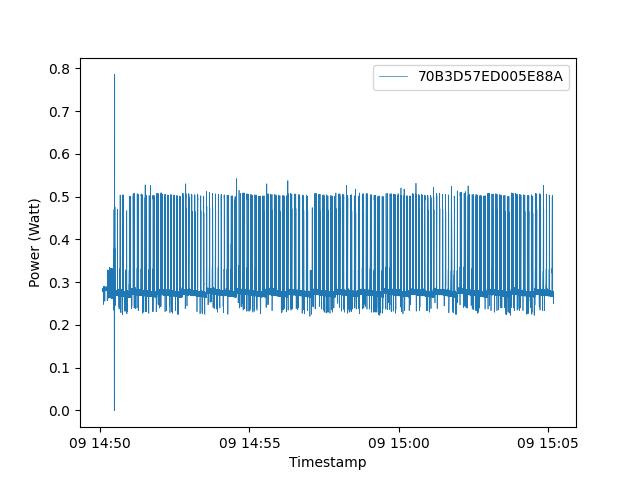

In [10]:
deveui = "70B3D57ED005EA56"

power_consumption= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.legend()
plt.show()

## finding sync signals

In [11]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

#diff of each group
power_consumption['power_diff'] = groups["power"].diff()
power_diff = power_consumption['power_diff']

# single node
power_single = power_consumption[(power_consumption["node_id"] =="70B3D57ED005E88A")]


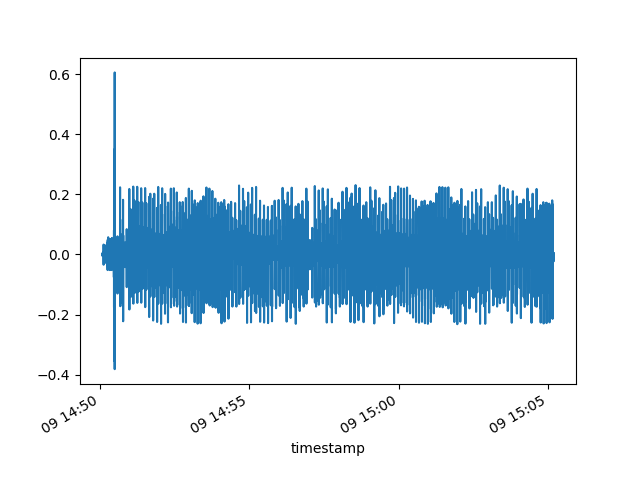

In [12]:
plt.figure()
power_diff.plot()
plt.show()

In [13]:
rising_edge = power_consumption[power_diff > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_diff < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2023-11-09 14:50:28.031725,0.291195,0.059851,4.86250,70B3D57ED005E88A,-0.175816,falling
2023-11-09 14:50:28.330671,0.000610,0.000147,3.06125,70B3D57ED005E88A,-0.266776,falling
2023-11-09 14:50:28.836106,0.368114,0.085222,4.59875,70B3D57ED005E88A,0.349800,rising
2023-11-09 14:50:28.837204,0.013430,0.002784,4.86375,70B3D57ED005E88A,-0.354684,falling
2023-11-09 14:50:29.390454,0.785677,0.162141,4.82000,70B3D57ED005E88A,0.605588,rising
...,...,...,...,...,...,...
2023-11-09 15:05:08.178795,0.457854,0.094257,4.85500,70B3D57ED005E88A,0.180090,rising
2023-11-09 15:05:08.378845,0.361399,0.074307,4.86125,70B3D57ED005E88A,-0.136746,falling
2023-11-09 15:05:08.595159,0.494482,0.101802,4.85875,70B3D57ED005E88A,0.167880,rising


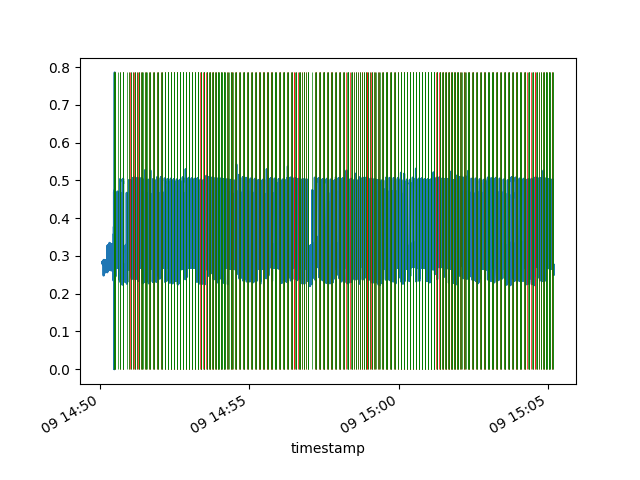

In [14]:
plt.figure()
power_single['power'].plot(label="power")
plt.vlines(edges[edges['direction'] == 'rising'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges[edges['direction'] == 'falling'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)

plt.show()

In [15]:
# only keep edges where direction differ
edges['next_direction'] = edges['direction'].shift(-1)
edges['next_timestamp'] = edges.index.to_series().shift(-1)
edges = edges[(edges['direction'] != edges['next_direction']) & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=210))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=190)))]
edges


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
timestamp,,,,,,,,
2023-11-09 14:50:40.222359,0.497534,0.102462,4.85750,70B3D57ED005E88A,0.223432,rising,falling,2023-11-09 14:50:40.422379
2023-11-09 14:50:45.764960,0.498145,0.102535,4.85625,70B3D57ED005E88A,0.108664,rising,falling,2023-11-09 14:50:45.964980
2023-11-09 14:50:46.180195,0.498145,0.102535,4.85750,70B3D57ED005E88A,0.181921,rising,falling,2023-11-09 14:50:46.380215
2023-11-09 14:50:58.719818,0.494482,0.101802,4.85375,70B3D57ED005E88A,0.217938,rising,falling,2023-11-09 14:50:58.919838
2023-11-09 14:51:01.135127,0.419394,0.086369,4.85875,70B3D57ED005E88A,0.151397,rising,falling,2023-11-09 14:51:01.336245
...,...,...,...,...,...,...,...,...
2023-11-09 15:04:56.689771,0.500587,0.103072,4.85625,70B3D57ED005E88A,0.171543,rising,falling,2023-11-09 15:04:56.889790
2023-11-09 15:05:02.226116,0.443202,0.091253,4.85125,70B3D57ED005E88A,0.169100,rising,falling,2023-11-09 15:05:02.426136
2023-11-09 15:05:02.642450,0.501197,0.103170,4.85500,70B3D57ED005E88A,0.164217,rising,falling,2023-11-09 15:05:02.842469


In [16]:
edges.loc[:,'sync_num'] = range(len(edges)) 
edges

/tmp/ipykernel_329445/4149730090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges.loc[:,'sync_num'] = range(len(edges))


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num
timestamp,,,,,,,,,
2023-11-09 14:50:40.222359,0.497534,0.102462,4.85750,70B3D57ED005E88A,0.223432,rising,falling,2023-11-09 14:50:40.422379,0
2023-11-09 14:50:45.764960,0.498145,0.102535,4.85625,70B3D57ED005E88A,0.108664,rising,falling,2023-11-09 14:50:45.964980,1
2023-11-09 14:50:46.180195,0.498145,0.102535,4.85750,70B3D57ED005E88A,0.181921,rising,falling,2023-11-09 14:50:46.380215,2
2023-11-09 14:50:58.719818,0.494482,0.101802,4.85375,70B3D57ED005E88A,0.217938,rising,falling,2023-11-09 14:50:58.919838,3
2023-11-09 14:51:01.135127,0.419394,0.086369,4.85875,70B3D57ED005E88A,0.151397,rising,falling,2023-11-09 14:51:01.336245,4
...,...,...,...,...,...,...,...,...,...
2023-11-09 15:04:56.689771,0.500587,0.103072,4.85625,70B3D57ED005E88A,0.171543,rising,falling,2023-11-09 15:04:56.889790,234
2023-11-09 15:05:02.226116,0.443202,0.091253,4.85125,70B3D57ED005E88A,0.169100,rising,falling,2023-11-09 15:05:02.426136,235
2023-11-09 15:05:02.642450,0.501197,0.103170,4.85500,70B3D57ED005E88A,0.164217,rising,falling,2023-11-09 15:05:02.842469,236


In [17]:
#based on sync_num add loop timings
edges.loc[:,'loop_num'] = ((edges['sync_num'] - 1) // 2)
edges

/tmp/ipykernel_329445/2219274201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges.loc[:,'loop_num'] = ((edges['sync_num'] - 1) // 2)


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,loop_num
timestamp,,,,,,,,,,
2023-11-09 14:50:40.222359,0.497534,0.102462,4.85750,70B3D57ED005E88A,0.223432,rising,falling,2023-11-09 14:50:40.422379,0,-1
2023-11-09 14:50:45.764960,0.498145,0.102535,4.85625,70B3D57ED005E88A,0.108664,rising,falling,2023-11-09 14:50:45.964980,1,0
2023-11-09 14:50:46.180195,0.498145,0.102535,4.85750,70B3D57ED005E88A,0.181921,rising,falling,2023-11-09 14:50:46.380215,2,0
2023-11-09 14:50:58.719818,0.494482,0.101802,4.85375,70B3D57ED005E88A,0.217938,rising,falling,2023-11-09 14:50:58.919838,3,1
2023-11-09 14:51:01.135127,0.419394,0.086369,4.85875,70B3D57ED005E88A,0.151397,rising,falling,2023-11-09 14:51:01.336245,4,1
...,...,...,...,...,...,...,...,...,...,...
2023-11-09 15:04:56.689771,0.500587,0.103072,4.85625,70B3D57ED005E88A,0.171543,rising,falling,2023-11-09 15:04:56.889790,234,116
2023-11-09 15:05:02.226116,0.443202,0.091253,4.85125,70B3D57ED005E88A,0.169100,rising,falling,2023-11-09 15:05:02.426136,235,117
2023-11-09 15:05:02.642450,0.501197,0.103170,4.85500,70B3D57ED005E88A,0.164217,rising,falling,2023-11-09 15:05:02.842469,236,117


In [18]:
# create table of loops by taking every second row and excluding the first edge (which is just program start)
# the index is when (we think) the loop starts. that is 100 ms after next_timestamp.
# also remove all irrelevant columns

loops = edges[['node_id', 'next_timestamp', 'loop_num']].iloc[1::2,:]
## change index to be loop start time. i.e. 200 ms after next timestamp
loops['loop_start'] = loops.next_timestamp + pd.Timedelta(milliseconds=100)
loops.set_index('loop_start', inplace=True)
loops.drop('next_timestamp', axis=1, inplace=True)
loops.head()

,node_id,loop_num
loop_start,,
2023-11-09 14:50:46.064980,70B3D57ED005E88A,0
2023-11-09 14:50:59.019838,70B3D57ED005E88A,1
2023-11-09 14:51:06.972316,70B3D57ED005E88A,2
2023-11-09 14:51:14.924855,70B3D57ED005E88A,3
2023-11-09 14:51:22.877363,70B3D57ED005E88A,4


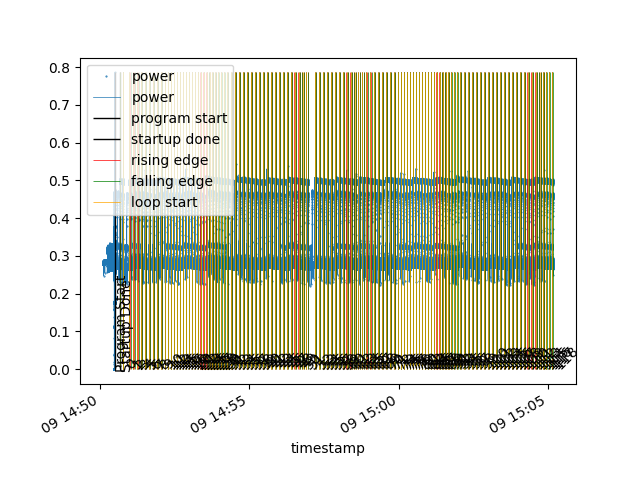

In [19]:
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")

# when does the program start?
%sql program_start << select timestamp from Trace WHERE message LIKE 'Terra%'
%sql startup_done << select timestamp from Trace WHERE message LIKE 'Startup done.%'
# add line indicating program start
plt.vlines(program_start['timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="black", linewidth=1, label="program start")
plt.text(program_start['timestamp'], 0, "Program Start", rotation=90)

# # add line indicating startup done
plt.vlines(startup_done['timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="black", linewidth=1, label="startup done")
plt.text(startup_done['timestamp'], 0, "Startup Done", rotation=90)

plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5, label="rising edge")
plt.vlines(edges['next_timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5, label="falling edge")
plt.vlines(loops.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="orange", linewidth=0.5, label="loop start")
for row in loops.itertuples():

    #odd row num indicates start sync
    plt.text(row.Index, 0, row.loop_num, rotation=45)
plt.legend()
plt.show()

In [20]:
%%sql
timings << 
select 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: ([0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: ([0-9]+)',1) as sync_time,
    regexp_extract(message, '.*Listen: ([0-9]+)',1) as listen_time,
    regexp_extract(message, '.*Collect: ([0-9]+)',1) as collect_time,
    regexp_extract(message, '.*Exec: ([0-9]+)',1) as exec_time,
    regexp_extract(message, '.*Send: ([0-9]+)',1) as send_time,
    regexp_extract(message, '.*Sleep: ([0-9]+)',1) as sleep_time,
    regexp_extract(message, '.*Total: ([0-9]+)',1) as total_time
     from Trace WHERE message LIKE 'TIMINGS>%'

In [21]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time', 'listen_time', 'collect_time', 'exec_time', 'send_time', 'sleep_time', 'total_time']] = timings[['loop_num', 'sync_time', 'listen_time', 'collect_time', 'exec_time', 'send_time', 'sleep_time', 'total_time']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_start')
loops.head()

,node_id,loop_num,timestamp,sync_time,listen_time,collect_time,exec_time,send_time,sleep_time,total_time
loop_start,,,,,,,,,,
2023-11-09 14:50:46.064980,70B3D57ED005E88A,0,2023-11-09 14:50:46.076068,403,0,28,0,5104,0,5539
2023-11-09 14:50:59.019838,70B3D57ED005E88A,1,2023-11-09 14:50:59.032268,403,0,28,0,12101,0,12536
2023-11-09 14:51:06.972316,70B3D57ED005E88A,2,2023-11-09 14:51:06.984363,403,1,28,0,5098,0,5534
2023-11-09 14:51:14.924855,70B3D57ED005E88A,3,2023-11-09 14:51:14.936496,403,0,28,0,5098,0,5533
2023-11-09 14:51:22.877363,70B3D57ED005E88A,4,2023-11-09 14:51:22.889586,403,1,28,1,5098,0,5534


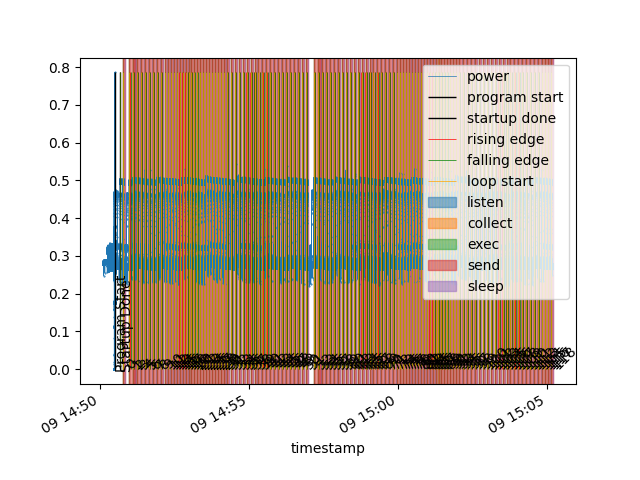

In [22]:
for row in loops.itertuples():
    start_time = row.Index
    listen_time_start = start_time
    listen_time_end = start_time + pd.Timedelta(milliseconds=row.listen_time)
    collect_time_start = listen_time_end
    collect_time_end = collect_time_start + pd.Timedelta(milliseconds=row.collect_time)
    exec_time_start = collect_time_end
    exec_time_end = exec_time_start + pd.Timedelta(milliseconds=row.exec_time)
    send_time_start = exec_time_end
    send_time_end = send_time_start + pd.Timedelta(milliseconds=row.send_time)
    sleep_time_start = send_time_end
    sleep_time_end = sleep_time_start + pd.Timedelta(milliseconds=row.sleep_time)
    plt.axvspan(listen_time_start, listen_time_end, color='tab:blue', alpha=0.5, label="listen")
    plt.axvspan(collect_time_start, collect_time_end, color='tab:orange', alpha=0.5, label="collect")
    plt.axvspan(exec_time_start, exec_time_end, color='tab:green', alpha=0.5, label="exec")
    plt.axvspan(send_time_start, send_time_end, color='tab:red', alpha=0.5, label="send")
    plt.axvspan(sleep_time_start, sleep_time_end, color='tab:purple', alpha=0.5, label="sleep")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [23]:
%sql select * from Trace

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-09 14:50:29.724860,�OF�
1,2,70B3D57ED005E88A,2023-11-09 14:50:29.727818,[auto_init_saul] initializing GPIO #1\n
2,3,70B3D57ED005E88A,2023-11-09 14:50:29.731684,[auto_init_saul] initializing GPIO #2\n
3,4,70B3D57ED005E88A,2023-11-09 14:50:29.734688,[auto_init_saul] initializing GPIO #3\n
4,5,70B3D57ED005E88A,2023-11-09 14:50:29.739689,[auto_init_saul] initializing hts221 #0\n
...,...,...,...,...
1836,1837,70B3D57ED005E88A,2023-11-09 15:05:08.919865,collecting data from sensor lps22hb\n
1837,1838,70B3D57ED005E88A,2023-11-09 15:05:08.926177,Read value from Sensor lps22hb. Saving in env...
1838,1839,70B3D57ED005E88A,2023-11-09 15:05:08.927853,Execute Queries...\n
1839,1840,70B3D57ED005E88A,2023-11-09 15:05:08.929865,Sending Responses if any...\n


In [24]:
%%sql
res <<
select timestamp, AVG(power) OVER blink AS 'avg_power_blink'
FROM Power_Consumption
WINDOW blink AS (
    PARTITION BY node_id
    ORDER BY timestamp ASC
    RANGE BETWEEN INTERVAL 100 MILLISECOND PRECEDING AND INTERVAL 100 MILLISECOND FOLLOWING
    )

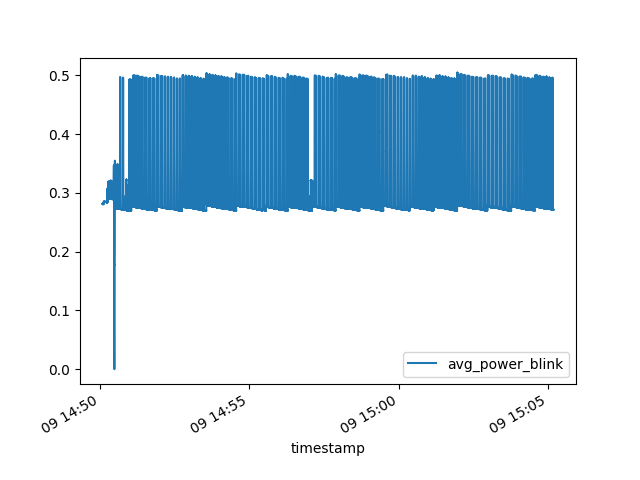

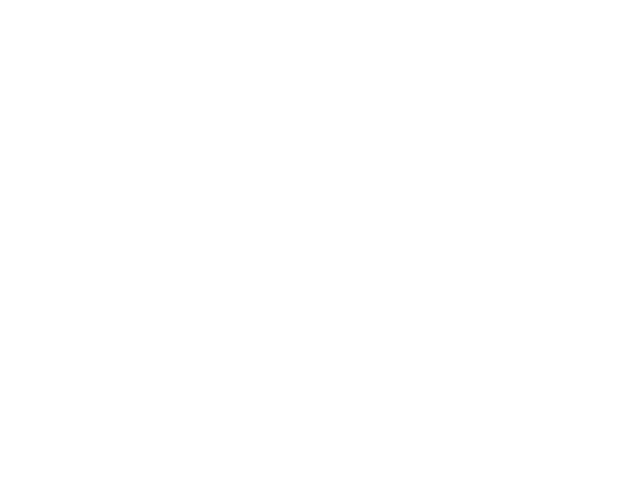

In [25]:
plt.figure()
res.plot(x='timestamp')
plt.show()

In [26]:
# Clean edge detection
#remove values where difference is not greater or less than 5 seconds
diff = filtered_power_diff.index.to_series().diff(-1).abs()
plt.figure()
plt.ylabel("Power")
# single node

power_single["power"].plot()

plt.vlines(filtered_power_diff.index[(diff < pd.Timedelta(seconds=5.5))  & (diff > pd.Timedelta(seconds=4.5))], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

NameError: name 'filtered_power_diff' is not defined

In [ ]:
%sql select count(*) from Trace

,count_star()
0,607


In [ ]:
#traces from single node
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A'

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-02 10:44:44.111270,�'/!8@!8UP�����Join procedure succeededcreatin...
1,2,70B3D57ED005E88A,2023-11-02 10:44:44.111979,Sending: <3\n
2,3,70B3D57ED005E88A,2023-11-02 10:44:49.218133,"Startup done. Timings: sensor init: 14 ms, env..."
3,4,70B3D57ED005E88A,2023-11-02 10:44:49.220100,Main loop iteration\n
4,5,70B3D57ED005E88A,2023-11-02 10:44:49.222096,Running single blink...\n
...,...,...,...,...
602,603,70B3D57ED005E88A,2023-11-02 10:49:19.918121,collecting data from sensor lps22hb\n
603,604,70B3D57ED005E88A,2023-11-02 10:49:19.924045,Read value from Sensor lps22hb. Saving in env...
604,605,70B3D57ED005E88A,2023-11-02 10:49:19.926032,Execute Queries...\n
605,606,70B3D57ED005E88A,2023-11-02 10:49:19.928118,Sending Responses if any...\n


In [ ]:
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A' AND message LIKE '>TIMINGS%'

,trace_id,node_id,timestamp,message


In [ ]:
def get_timings_from_trace(trace: str):
    

SyntaxError: incomplete input (2969963752.py, line 2)

In [ ]:
# lower=widgets.SelectionSlider(options=timestamps, value=timestamps.min())
# upper=widgets.SelectionSlider(options=timestamps, value=timestamps.max())
# %sql --save hej --interact deveuis --interact lower --interact upper SELECT * from Power_Consumption where node_id LIKE '{{deveuis}}' AND timestamp BETWEEN '{{lower}}' AND '{{upper}}'